In [1]:
import os
import json
import pandas as pd
import pysrt
import re

In [2]:
def save_json(content, save_path):
    with open(save_path, 'w') as f:
        f.write(json.dumps(content))
def load_jsonl(filename):
    with open(filename, "r") as f:
        return [json.loads(l.strip("\n")) for l in f.readlines()]
def load_result_json(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    print(data)
    return data

In [3]:
eval_folder = "/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/evaluation/tvqa"
if not os.path.exists(eval_folder):
    os.makedirs(eval_folder)

vid_json_folder = "/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa_finetuned_on_full_without_audio"
if not os.path.exists(vid_json_folder):
    os.makedirs(vid_json_folder)

val_result_json_path = f"{vid_json_folder}/all_data_val_moment_retrieval_BEST_without_audio.json"
test_result_json_path = f"{vid_json_folder}/all_data_test_moment_retrieval_BEST_without_audio.json"
val_result_wa_json_path = f"{vid_json_folder}/all_data_val_moment_retrieval_BEST_with_audio.json"
test_result_wa_json_path = f"{vid_json_folder}/all_data_test_moment_retrieval_BEST_with_audio.json"

In [4]:
val = load_jsonl(f'{vid_json_folder}/all_data_val.json')
test = load_jsonl(f'{vid_json_folder}/all_data_test.json')
#clip_pred_med = load_jsonl(f'{vid_json_folder}/five_labeled_pred_med_vid_dict.json')

clip_pred_med = load_jsonl(f'{vid_json_folder}/five_labeled_pred_med_from_gt_vid_dict.json')
test_result = load_result_json(test_result_json_path)
val_result = load_result_json(val_result_json_path)
hirest_test_wa_result = load_result_json(test_result_wa_json_path)
hirest_val_wa_result = load_result_json(val_result_wa_json_path)

{"Who does Sheldon say he'll send an email to after coming out of the bathroom?": {'s03e21_seg02_clip_08.mp4': {'bounds': [15, 22], 'video_duration': 61}}, 'How long did Gina say he was on the phone with Castle after Gine introduced herself?': {'castle_s02e24_seg02_clip_26.mp4': {'bounds': [40, 36], 'video_duration': 89}}, 'Where did Masters actually go after she left the operating room?': {'house_s07e19_seg02_clip_12.mp4': {'bounds': [25, 25], 'video_duration': 98}}, 'How did Addie try to kill herself when House found out why she was in that condition?': {'house_s03e22_seg02_clip_23.mp4': {'bounds': [50, 50], 'video_duration': 90}}, 'What is House holding when Wilson stands up and leaves?': {'house_s04e03_seg02_clip_06.mp4': {'bounds': [30, 36], 'video_duration': 93}}, 'What is Cameron looking into before House walks into the office?': {'house_s01e08_seg02_clip_03.mp4': {'bounds': [61, 36], 'video_duration': 90}}, 'What does Beckett hold in her hand when she approaches the man? ': {'c

In [5]:
def extract_speaker(subtitle_speaker_dict, video_name, root_path='/home/hlpark/shared/TVQA/tvqa_subtitles'):

    key = ""
    if "house" in video_name:
        key = "house"
    elif "grey" in video_name:
        key = "grey"
    elif "met" in video_name:
        key = "met"
    elif "friend" in video_name:
        key = "friend"
    elif "castle" in video_name:
        key = "castle"
    else:
        key = "bbt"
    if key not in subtitle_speaker_dict:
        subtitle_speaker_dict[key] = []
    subtitle_path = os.path.join(root_path, video_name + ".srt")
    print(subtitle_path)
    subtitle = pysrt.open(subtitle_path)
    for sub in subtitle:
        pattern = r'\(([^:]+):\)'  # This pattern captures everything between ( and :)
        names = re.findall(pattern, sub.text)
        # print(names)
        if len(names) > 0:
            for name in names:
                name = name.lower().replace(".", "")
                if name not in subtitle_speaker_dict[key]:
                    subtitle_speaker_dict[key].append(name)


In [6]:
def compute_iou(interval_1, interval_2):
    start_i, end_i = float(interval_1[0]), float(interval_1[1])
    start, end = float(interval_2[0]), float(interval_2[1])
    intersection = max(0, min(end, end_i) - max(start, start_i))
    union = min(max(end, end_i) - min(start, start_i), end-start + end_i-start_i)
    iou = float(intersection) / (union + 1e-8)
    return iou

In [7]:
def save_categorized_data(low_thresh, high_thresh, iou, dict, key, vid, value):
    if "house" in vid or "grey" in vid:
        category = "med"
    else: 
        category = "nonmed"
    if iou < low_thresh:
        div = "low"
    elif iou >= high_thresh:
        div = "high"
    else:
        return
    if 'queries' not in dict[category][div]:
        dict[category][div]['queries'] = []
        dict[category][div]['videos'] = []
        dict[category][div]['duration'] = []
        dict[category][div]['gt_time_span'] = []
    else:
        dict[category][div]['queries'].append(key)
        dict[category][div]['videos'].append(vid)
        dict[category][div]['duration'].append(value[vid]['v_duration'])
        dict[category][div]['gt_time_span'].append(float(value[vid]['bounds'][1]) - float(value[vid]['bounds'][0]))
    

In [8]:
test_med_queries_path = "/home/hlpark/shared/TVQA/output_gpt_tvqa_test_queries.txt"
val_med_queries_path = "/home/hlpark/shared/TVQA/output_gpt_tvqa_val_queries.txt"
test_med_query_f_metamap_list, val_med_query_f_metamap_list = [], []
with open(test_med_queries_path, "r") as f:
    lines = f.read()
    for line in lines.split("\n"):
        if line == "\n" or line == "":
            continue
        if line.startswith(" ") or line.startswith("-"):
            line = line.lstrip("-").lstrip(" ")
        test_med_query_f_metamap_list.append(line.lower().replace(" ", "").replace("?", "").replace("\n", "").replace("-", "").replace("'", "").replace("\"", "").replace(",", "").replace(".", "").replace("/", "").replace(">", ""))
f.close()
with open(val_med_queries_path, "r") as f:
    lines = f.read()
    for line in lines.split("\n"):
        if line == "\n" or line == "":
            continue
        # if line.startswith(" ") or line.startswith("-"):
        #     line = line.lstrip("-").lstrip(" ")
        val_med_query_f_metamap_list.append(line.lower().replace(" ", "").replace("?", "").replace("\n", "").replace("-", "").replace("'", "").replace("\"", "").replace(",", "").replace(".", "").replace("/", "").replace(">", ""))
        #val_med_query_f_metamap_list.append(line.strip(" ").strip("\n").replace("  ", " "))
f.close()
print(len(test_med_query_f_metamap_list), len(val_med_query_f_metamap_list))

246 569


In [9]:
#store speaker information
subtitle_speaker_dict = {}
for key, value in test[0].items():
    vid = next(iter(value))
    print(vid)
    extract_speaker(subtitle_speaker_dict, vid.replace(".mp4", ""))

for key, value in val[0].items():
    vid = next(iter(value))
    extract_speaker(subtitle_speaker_dict, vid.replace(".mp4", ""))

s03e21_seg02_clip_08.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/s03e21_seg02_clip_08.srt
castle_s02e24_seg02_clip_26.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/castle_s02e24_seg02_clip_26.srt
house_s07e19_seg02_clip_12.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/house_s07e19_seg02_clip_12.srt
house_s03e22_seg02_clip_23.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/house_s03e22_seg02_clip_23.srt
house_s04e03_seg02_clip_06.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/house_s04e03_seg02_clip_06.srt
house_s01e08_seg02_clip_03.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/house_s01e08_seg02_clip_03.srt
castle_s06e11_seg02_clip_26.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/castle_s06e11_seg02_clip_26.srt
castle_s04e04_seg02_clip_26.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/castle_s04e04_seg02_clip_26.srt
castle_s05e24_seg02_clip_22.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/castle_s05e24_seg02_clip_22.srt
castle_s02e09_seg02_clip_23.mp4
/home/hlpark/shared/TVQA/tvqa_subtitles/castle_s02e09_

In [10]:
select_option = "med_queries"
# select_option = "med_samples_clip_from_gt"
# select_option = "med_samples_clip_full_rand"
# select_option = "tv shows"

In [11]:
print("HiREST without Audio " + select_option)
iou_thresh_3, iou_thresh_5, iou_thresh_7, total, queries_cnt = 0, 0, 0, 0, 0
med_iou_thresh_3, med_iou_thresh_5, med_iou_thresh_7, med_total = 0, 0, 0, 0
nonmed_iou_thresh_3, nonmed_iou_thresh_5, nonmed_iou_thresh_7, nonmed_total = 0, 0, 0, 0
test_woa_under_thresh, test_wa_under_thresh, val_woa_under_thresh, val_wa_under_thresh = {'med': {'low':{}, 'high': {}}, 'nonmed':{'low':{}, 'high': {}}}, {'med': {'low':{}, 'high': {}}, 'nonmed':{'low':{}, 'high': {}}}, {'med': {'low':{}, 'high': {}}, 'nonmed':{'low':{}, 'high': {}}}, {'med': {'low':{}, 'high': {}}, 'nonmed':{'low':{}, 'high': {}}}
for key, value in test[0].items():
    if key in test_result:
        vid = next(iter(value))
        #print(value[vid]['bounds'])

        iou = compute_iou(value[vid]['bounds'], test_result[key][vid]['bounds'])
        save_categorized_data(0.3, 0.5, iou, test_woa_under_thresh, key, vid, value)
        if iou >= 0.3:
            iou_thresh_3 += 1 
        if iou >= 0.5:
            iou_thresh_5 += 1 
        if iou >= 0.7:
            iou_thresh_7 += 1 
        total += 1
        ismed = False
        if select_option == "tv shows":
            if "house" in vid or "grey" in vid:
                ismed = True
        elif select_option == "med_samples_clip_full_rand":
            if clip_pred_med[0][vid] == "med":
               ismed = True
        elif select_option == "med_samples_clip_from_gt":
            for qc in clip_pred_med[0][vid.replace(".mp4", "")]:
                #print(qc)
                if key in qc and qc[key] == "med":
                    ismed = True
        elif select_option == "med_queries":
            newkey = key.lower().replace(" ", "").replace("?", "").replace("\n", "").replace("-", "").replace("'", "").replace("\"", "").replace(">", "").replace(",", "").replace(".", "").replace("/", "")
            if newkey  in test_med_query_f_metamap_list:
                ismed = True
        if ismed:
            med_total += 1
            if iou >= 0.3:
                med_iou_thresh_3 += 1 
            if iou >= 0.5:
                med_iou_thresh_5 += 1 
            if iou >= 0.7:
                med_iou_thresh_7 += 1 
        else:
            nonmed_total += 1
            if iou >= 0.3:
                nonmed_iou_thresh_3 += 1 
            if iou >= 0.5:
                nonmed_iou_thresh_5 += 1 
            if iou >= 0.7:
                nonmed_iou_thresh_7 += 1 
    else:
        print("Not found")
    queries_cnt += 1

print(f"TEST IoU=0.3: {iou_thresh_3/(total) * 100}\nIoU=0.5: {iou_thresh_5/(total) * 100}\nIoU=0.7: {iou_thresh_7/(total) * 100}\ntotal queries:{(total)}/{queries_cnt}")
print(med_iou_thresh_3, nonmed_iou_thresh_3, med_total, nonmed_total)
print(f"TEST Medical IoU=0.3: {med_iou_thresh_3/(med_total) * 100}\nIoU=0.5: {med_iou_thresh_5/(med_total) * 100}\nIoU=0.7: {med_iou_thresh_7/(med_total) * 100}\ntotal queries:{(med_total)}/{queries_cnt}")
print(f"TEST Non-Medical IoU=0.3: {nonmed_iou_thresh_3/(nonmed_total) * 100}\nIoU=0.5: {nonmed_iou_thresh_5/(nonmed_total) * 100}\nIoU=0.7: {nonmed_iou_thresh_7/(nonmed_total) * 100}\ntotal queries:{(nonmed_total)}/{queries_cnt}")

iou_thresh_3, iou_thresh_5, iou_thresh_7, total, queries_cnt = 0, 0, 0, 0, 0
med_iou_thresh_3, med_iou_thresh_5, med_iou_thresh_7, med_total = 0, 0, 0, 0
nonmed_iou_thresh_3, nonmed_iou_thresh_5, nonmed_iou_thresh_7, nonmed_total = 0, 0, 0, 0
for key, value in val[0].items():
    if key in val_result:
        vid = next(iter(value))
        #print(vid)
        iou = compute_iou(value[vid]['bounds'], val_result[key][vid]['bounds'])
        save_categorized_data(0.3, 0.5, iou, val_woa_under_thresh, key, vid, value)
        if iou >= 0.3:
            iou_thresh_3 += 1 
        if iou >= 0.5:
            iou_thresh_5 += 1 
        if iou >= 0.7:
            iou_thresh_7 += 1 
        total += 1
        ismed = False
        if select_option == "tv shows":
            if "house" in vid or "grey" in vid:
                ismed = True
        elif select_option == "med_samples_clip_full_rand":
            if clip_pred_med[0][vid] == "med":
               ismed = True
        elif select_option == "med_samples_clip_from_gt":
            for qc in clip_pred_med[0][vid.replace(".mp4", "")]:
                #print(qc)
                if key in qc and qc[key] == "med":
                    ismed = True
        elif select_option == "med_queries":
            newkey = key.lower().replace(" ", "").replace("?", "").replace("\n", "").replace("-", "").replace("'", "").replace("\"", "").replace(">", "").replace(",", "").replace(".", "").replace("/", "")
            if newkey  in val_med_query_f_metamap_list:
                ismed = True
        if ismed:
            med_total += 1
            if iou >= 0.3:
                med_iou_thresh_3 += 1 
            if iou >= 0.5:
                med_iou_thresh_5 += 1 
            if iou >= 0.7:
                med_iou_thresh_7 += 1 
        else:
            nonmed_total += 1
            if iou >= 0.3:
                nonmed_iou_thresh_3 += 1 
            if iou >= 0.5:
                nonmed_iou_thresh_5 += 1 
            if iou >= 0.7:
                nonmed_iou_thresh_7 += 1 
    else:
        print(f" not found")
    queries_cnt += 1

print(f"\n\nVAL IoU=0.3: {iou_thresh_3/(total) * 100}\nIoU=0.5: {iou_thresh_5/(total) * 100}\nIoU=0.7: {iou_thresh_7/(total) * 100}\ntotal queries:{(total)}/{queries_cnt}")
print(med_iou_thresh_3, nonmed_iou_thresh_3, med_total, nonmed_total)
print(f"VAL Medical IoU=0.3: {med_iou_thresh_3/(med_total) * 100}\nIoU=0.5: {med_iou_thresh_5/(med_total) * 100}\nIoU=0.7: {med_iou_thresh_7/(med_total) * 100}\ntotal queries:{(med_total)}/{queries_cnt}")
print(f"VAL Non-Medical IoU=0.3: {nonmed_iou_thresh_3/(nonmed_total) * 100}\nIoU=0.5: {nonmed_iou_thresh_5/(nonmed_total) * 100}\nIoU=0.7: {nonmed_iou_thresh_7/(nonmed_total) * 100}\ntotal queries:{(nonmed_total)}/{queries_cnt}")


HiREST without Audio med_queries
TEST IoU=0.3: 6.93095300603833
IoU=0.5: 2.6516145970070886
IoU=0.7: 0.6694670517196115
total queries:7618/7618
11 517 246 7372
TEST Medical IoU=0.3: 4.471544715447155
IoU=0.5: 1.6260162601626018
IoU=0.7: 0.8130081300813009
total queries:246/7618
TEST Non-Medical IoU=0.3: 7.013022246337493
IoU=0.5: 2.685838307107976
IoU=0.7: 0.6646771568095496
total queries:7372/7618


VAL IoU=0.3: 7.557071634741537
IoU=0.5: 3.0175806874836
IoU=0.7: 0.7609551298871687
total queries:15244/15244
36 1116 569 14675
VAL Medical IoU=0.3: 6.32688927943761
IoU=0.5: 2.460456942003515
IoU=0.7: 0.8787346221441126
total queries:569/15244
VAL Non-Medical IoU=0.3: 7.604770017035775
IoU=0.5: 3.0391822827938673
IoU=0.7: 0.7563884156729132
total queries:14675/15244


In [12]:
print("HiREST with audio " + select_option)
iou_thresh_3, iou_thresh_5, iou_thresh_7, total, queries_cnt = 0, 0, 0, 0, 0
med_iou_thresh_3, med_iou_thresh_5, med_iou_thresh_7, med_total = 0, 0, 0, 0
nonmed_iou_thresh_3, nonmed_iou_thresh_5, nonmed_iou_thresh_7, nonmed_total = 0, 0, 0, 0

for key, value in test[0].items():
    if key in hirest_test_wa_result:
        vid = next(iter(value))
        #print(value[vid]['bounds'])

        iou = compute_iou(value[vid]['bounds'], hirest_test_wa_result[key][vid]['bounds'])
        save_categorized_data(0.3, 0.5, iou, test_wa_under_thresh, key, vid, value)
        if iou >= 0.3:
            iou_thresh_3 += 1 
        if iou >= 0.5:
            iou_thresh_5 += 1 
        if iou >= 0.7:
            iou_thresh_7 += 1 
        total += 1
        ismed = False
        if select_option == "tv shows":
            if "house" in vid or "grey" in vid:
                ismed = True
        elif select_option == "med_samples_clip_full_rand":
            if clip_pred_med[0][vid] == "med":
               ismed = True
        elif select_option == "med_samples_clip_from_gt":
            for qc in clip_pred_med[0][vid.replace(".mp4", "")]:
                #print(qc)
                if key in qc and qc[key] == "med":
                    ismed = True
        elif select_option == "med_queries":
            newkey = key.lower().replace(" ", "").replace("?", "").replace("\n", "").replace("-", "").replace("'", "").replace("\"", "").replace(">", "").replace(",", "").replace(".", "").replace("/", "")
            if newkey  in test_med_query_f_metamap_list:
                ismed = True
        if ismed:
            med_total += 1
            if iou >= 0.3:
                med_iou_thresh_3 += 1 
            if iou >= 0.5:
                med_iou_thresh_5 += 1 
            if iou >= 0.7:
                med_iou_thresh_7 += 1 
        else:
            nonmed_total += 1
            if iou >= 0.3:
                nonmed_iou_thresh_3 += 1 
            if iou >= 0.5:
                nonmed_iou_thresh_5 += 1 
            if iou >= 0.7:
                nonmed_iou_thresh_7 += 1 
    else:
        print("Not found")
    queries_cnt += 1
print(f"TEST IoU=0.3: {iou_thresh_3/(total) * 100}\nIoU=0.5: {iou_thresh_5/(total) * 100}\nIoU=0.7: {iou_thresh_7/(total) * 100}\ntotal queries:{(total)}/{queries_cnt}")
print(f"TEST Medical IoU=0.3: {med_iou_thresh_3/(med_total) * 100}\nIoU=0.5: {med_iou_thresh_5/(med_total) * 100}\nIoU=0.7: {med_iou_thresh_7/(med_total) * 100}\ntotal queries:{(med_total)}/{queries_cnt}")
print(f"TEST Non-Medical IoU=0.3: {nonmed_iou_thresh_3/(nonmed_total) * 100}\nIoU=0.5: {nonmed_iou_thresh_5/(nonmed_total) * 100}\nIoU=0.7: {nonmed_iou_thresh_7/(nonmed_total) * 100}\ntotal queries:{(nonmed_total)}/{queries_cnt}")

iou_thresh_3, iou_thresh_5, iou_thresh_7, total, queries_cnt = 0, 0, 0, 0, 0
med_iou_thresh_3, med_iou_thresh_5, med_iou_thresh_7, med_total = 0, 0, 0, 0
nonmed_iou_thresh_3, nonmed_iou_thresh_5, nonmed_iou_thresh_7, nonmed_total = 0, 0, 0, 0
for key, value in val[0].items():
    if key in hirest_val_wa_result:
        vid = next(iter(value))
        #print(vid)
        iou = compute_iou(value[vid]['bounds'], hirest_val_wa_result[key][vid]['bounds'])
        save_categorized_data(0.3, 0.5, iou, val_wa_under_thresh, key, vid, value)
        if iou >= 0.3:
            iou_thresh_3 += 1 
        if iou >= 0.5:
            iou_thresh_5 += 1 
        if iou >= 0.7:
            iou_thresh_7 += 1 
        total += 1
        ismed = False
        if select_option == "tv shows":
            if "house" in vid or "grey" in vid:
                ismed = True
        elif select_option == "med_samples_clip_full_rand":
            if clip_pred_med[0][vid] == "med":
               ismed = True
        elif select_option == "med_samples_clip_from_gt":
            for qc in clip_pred_med[0][vid.replace(".mp4", "")]:
                #print(qc)
                if key in qc and qc[key] == "med":
                    ismed = True
        elif select_option == "med_queries":
            newkey = key.lower().replace(" ", "").replace("?", "").replace("\n", "").replace("-", "").replace("'", "").replace("\"", "").replace(">", "").replace(",", "").replace(".", "").replace("/", "")
            if newkey  in val_med_query_f_metamap_list:
                ismed = True
        if ismed:
            med_total += 1
            if iou >= 0.3:
                med_iou_thresh_3 += 1 
            if iou >= 0.5:
                med_iou_thresh_5 += 1 
            if iou >= 0.7:
                med_iou_thresh_7 += 1 
        else:
            nonmed_total += 1
            if iou >= 0.3:
                nonmed_iou_thresh_3 += 1 
            if iou >= 0.5:
                nonmed_iou_thresh_5 += 1 
            if iou >= 0.7:
                nonmed_iou_thresh_7 += 1 
    else:
        print(f" not found")
    queries_cnt += 1
print(f"\n\nVAL IoU=0.3: {iou_thresh_3/(total) * 100}\nIoU=0.5: {iou_thresh_5/(total) * 100}\nIoU=0.7: {iou_thresh_7/(total) * 100}\ntotal queries:{(total)}/{queries_cnt}")
print(f"VAL Medical IoU=0.3: {med_iou_thresh_3/(med_total) * 100}\nIoU=0.5: {med_iou_thresh_5/(med_total) * 100}\nIoU=0.7: {med_iou_thresh_7/(med_total) * 100}\ntotal queries:{(med_total)}/{queries_cnt}")
print(f"VAL Non-Medical IoU=0.3: {nonmed_iou_thresh_3/(nonmed_total) * 100}\nIoU=0.5: {nonmed_iou_thresh_5/(nonmed_total) * 100}\nIoU=0.7: {nonmed_iou_thresh_7/(nonmed_total) * 100}\ntotal queries:{(nonmed_total)}/{queries_cnt}")


HiREST with audio med_queries
TEST IoU=0.3: 7.731688107114729
IoU=0.5: 3.0979259648201625
IoU=0.7: 1.0370175899186138
total queries:7618/7618
TEST Medical IoU=0.3: 7.723577235772358
IoU=0.5: 3.2520325203252036
IoU=0.7: 0.40650406504065045
total queries:246/7618
TEST Non-Medical IoU=0.3: 7.731958762886598
IoU=0.5: 3.0927835051546393
IoU=0.7: 1.0580575149213238
total queries:7372/7618


VAL IoU=0.3: 8.114668066124377
IoU=0.5: 2.9454211493046447
IoU=0.7: 0.8790343741800053
total queries:15244/15244
VAL Medical IoU=0.3: 8.084358523725834
IoU=0.5: 1.9332161687170473
IoU=0.7: 0.7029876977152899
total queries:569/15244
VAL Non-Medical IoU=0.3: 8.115843270868824
IoU=0.5: 2.9846678023850086
IoU=0.7: 0.8858603066439523
total queries:14675/15244


In [25]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
from owlready2 import *
from owlready2.pymedtermino2 import *
from owlready2.pymedtermino2.umls import *
import pysrt
# default_world.set_backend(filename = "pym.sqlite3")
# import_umls("/home/hlpark/2023AB.zip", terminologies = ["ICD10", "SNOMEDCT_US", "CUI"])
# default_world.save()
# PYM = get_ontology("http://PYM/").load()
# SNOMEDCT_US = PYM["SNOMEDCT_US"]

bar_interval = 10
def group_lengths(lengths):
    grouped = defaultdict(int)
    for length in lengths:
        # Grouping by intervals of 5
        interval = bar_interval * (length // bar_interval)
        grouped[interval] += 1
    return grouped
def plot_bars(x1, x2, name1, name2, title, xlabel, ylabel):
    # Count the lengths of the strings in both lists
    print(x1)
    lengths1 = [len(s) for s in x1]
    grouped_lengths1 = group_lengths(lengths1)

    lengths2 = [len(s) for s in x2]
    grouped_lengths2 = group_lengths(lengths2)

    # Get a combined set of all unique length intervals
    all_intervals = sorted(set(grouped_lengths1.keys()).union(set(grouped_lengths2.keys())))

    # Prepare data for the bar plot
    instances1 = [grouped_lengths1[interval] for interval in all_intervals]
    instances2 = [grouped_lengths2[interval] for interval in all_intervals]


    # Set up the positions for the bars
    bar_width = 0.35
    index = np.arange(len(all_intervals))

    # Plotting the bar plot
    fig, ax = plt.subplots()
    bar1 = ax.bar(index, instances1, bar_width, label=name1)
    bar2 = ax.bar(index + bar_width, instances2, bar_width, label=name2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(all_intervals)
    ax.legend()

    plt.show()

def plot_bars_gt_distribution(x1, x2, name1, name2, title, xlabel, ylabel):
    # Count the lengths of the strings in both lists
    grouped_lengths1 = group_lengths(x1)

    grouped_lengths2 = group_lengths(x2)

    # Get a combined set of all unique length intervals
    all_intervals = sorted(set(grouped_lengths1.keys()).union(set(grouped_lengths2.keys())))

    # Prepare data for the bar plot
    instances1 = [grouped_lengths1[interval] for interval in all_intervals]
    instances2 = [grouped_lengths2[interval] for interval in all_intervals]


    # Set up the positions for the bars
    bar_width = 0.35
    index = np.arange(len(all_intervals))

    # Plotting the bar plot
    fig, ax = plt.subplots()
    bar1 = ax.bar(index, instances1, bar_width, label=name1)
    bar2 = ax.bar(index + bar_width, instances2, bar_width, label=name2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(all_intervals)
    ax.legend()

    plt.show()

def piechart(labels, sizes, title, root_path):
    # labels = ['Python', 'C++', 'Ruby', 'Java']
    # sizes = [215, 130, 245, 210]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'purple', 'red', 'orange', 'darkgreen', 'black']
    explode = (0, 0, 0, 0, 0.1, 0, 0.2, 0.4)  # explode 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=False, startangle=140)

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)
    
    plt.savefig(os.path.join(root_path, title) + ".png")
    plt.show()

# def search_medical_jargon(keyword):
#     output = SNOMEDCT_US.search(keyword)
#     print(output)

def check_query_type(factoid, inference, qlist):
    factoid_cnt, inference_cnt = 0, 0
    for q in qlist:
        if q in factoid:
            factoid_cnt += 1
        elif q in inference:
            inference_cnt +=1
    print("Factoid ", factoid_cnt, "Inference ", inference_cnt )

In [35]:
factoid_queries = []
inference_queries = []
for key, v in val[0].items():
    inference_keywords = ["before", "after", "why", "how", "what if", "reason"]
    for keywords in inference_keywords:
        if keywords in key.lower():
            inference_queries.append(key)
        else:
            factoid_queries.append(key)

for key, v in test[0].items():
    inference_keywords = ["before", "after", "why", "how", "what if", "reason"]
    for keywords in inference_keywords:
        if keywords in key.lower():
            inference_queries.append(key)
        else:
            factoid_queries.append(key)

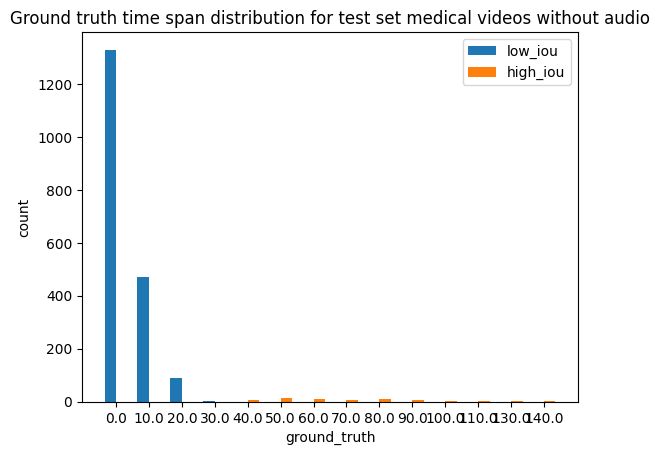

[0.0]


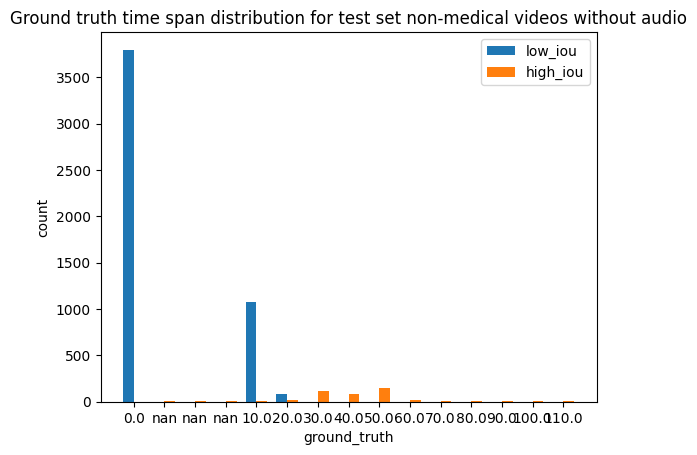

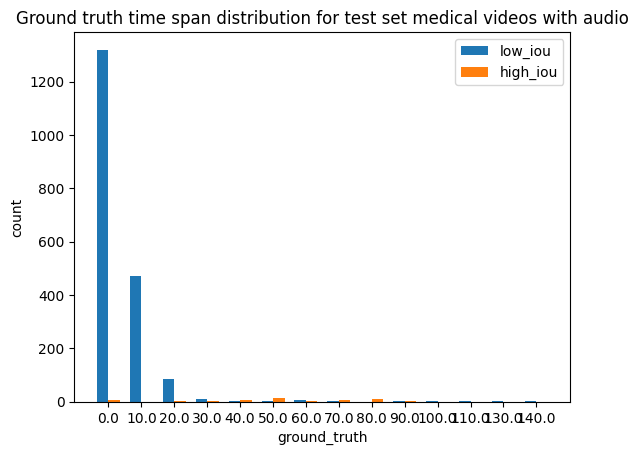

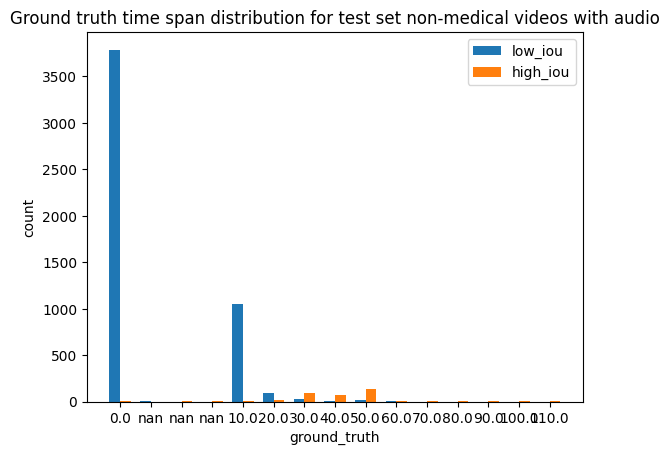

In [27]:
plot_bars_gt_distribution(test_woa_under_thresh['med']['low']['gt_time_span'], test_woa_under_thresh['med']['high']['gt_time_span'], "low_iou", "high_iou", "Ground truth time span distribution for test set medical videos without audio", "ground_truth", "count")
cnt = 0
k = [x for x in test_woa_under_thresh['med']['low']['gt_time_span'] if x == 0]
print(k)
plot_bars_gt_distribution(test_woa_under_thresh['nonmed']['low']['gt_time_span'], test_woa_under_thresh['nonmed']['high']['gt_time_span'], "low_iou", "high_iou", "Ground truth time span distribution for test set non-medical videos without audio", "ground_truth", "count")
plot_bars_gt_distribution(test_wa_under_thresh['med']['low']['gt_time_span'], test_wa_under_thresh['med']['high']['gt_time_span'], "low_iou", "high_iou", "Ground truth time span distribution for test set medical videos with audio", "ground_truth", "count")
plot_bars_gt_distribution(test_wa_under_thresh['nonmed']['low']['gt_time_span'], test_wa_under_thresh['nonmed']['high']['gt_time_span'], "low_iou", "high_iou", "Ground truth time span distribution for test set non-medical videos with audio", "ground_truth", "count")


In [33]:
assert len(test_woa_under_thresh['nonmed']['low']['gt_time_span']) == len(test_woa_under_thresh['nonmed']['low']['queries'])
assert len(test_woa_under_thresh['med']['low']['gt_time_span']) == len(test_woa_under_thresh['med']['low']['queries'])
assert len(test_woa_under_thresh['nonmed']['high']['gt_time_span']) == len(test_woa_under_thresh['nonmed']['high']['queries'])
assert len(test_woa_under_thresh['med']['high']['gt_time_span']) == len(test_woa_under_thresh['med']['high']['queries'])
for idx, q in enumerate(test_woa_under_thresh['med']['high']['queries']):
    if test_woa_under_thresh['med']['high']['gt_time_span'][idx] > 100:
        print(q)

How does Vicky react when mark holds Donna's hands?
What did Cuddy say when reffering to the fight she and House had?
What does Hugo do when he sees Cuddy and House fighting
Where and when did House talk about the muscle tear?
What does Cuddy mean when she says they are moving onto House's "expertise"
How does the girl react when Hugo says he wants her to take half of his lung?


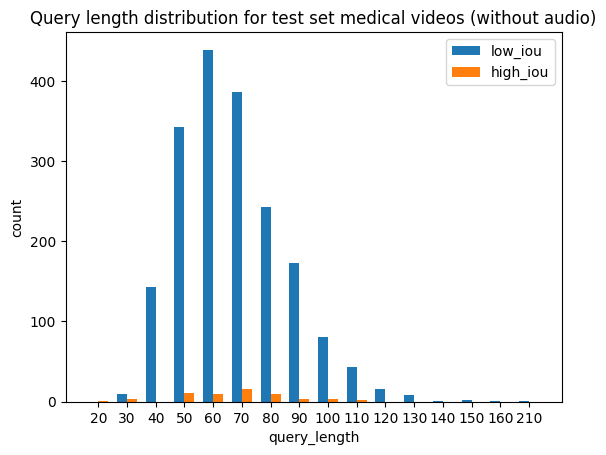

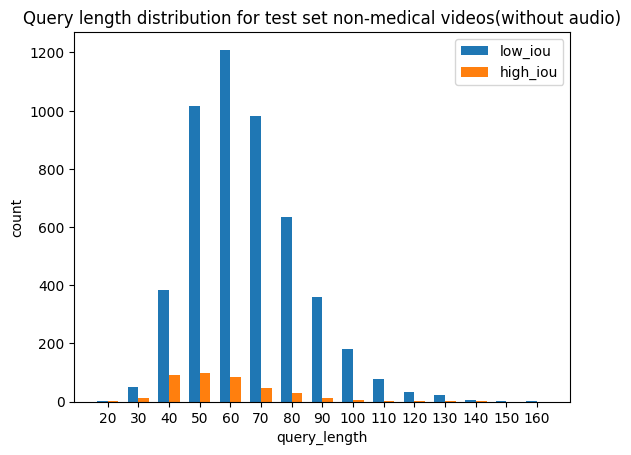

In [20]:

#compare audio and without audio result
plot_bars(test_woa_under_thresh['med']['low']['queries'], test_woa_under_thresh['med']['high']['queries'], "low_iou", "high_iou", "Query length distribution for test set medical videos (without audio)", "query_length", "count")
plot_bars(test_woa_under_thresh['nonmed']['low']['queries'], test_woa_under_thresh['nonmed']['high']['queries'], "low_iou", "high_iou", "Query length distribution for test set non-medical videos(without audio)", "query_length", "count")

In [21]:
print(subtitle_speaker_dict['house'])

['resident', 'nurse hoffner', 'simpson', 'masters', 'foreman', 'taub', 'chase', 'thirteen', 'house', 'addie', 'wilson', 'amber', 'cole', 'kutner', 'brennan', 'stark', 'cameron', 'karen', "nurse's voice", 'stacy', 'molly', 'lee', 'adams', 'park', 'jane doe', 'lida', 'bill', 'chris taub', '"thirteen"', 'greg house', 'james wilson', 'mom', 'clementine', "house's attorney", 'judge winter', 'cuddy', 'henry (overjoyed)', 'henry', 'dominika', 'cab driver', 'dave', 'cate', 'mother', 'eddie', 'keo', 'stuart', 'will', 'pharmacist', 'safer', 'alvie', 'maria', 'andie', 'rodney', 'girl', 'cruz', 'elizabeth', 'fletcher', 'derrick', 'jen', 'joe', 'kenny', 'volakis', 'jerry', 'becca', 'lola', 'hank', 'daniel', 'rachel', 'cynthia', 'hannah', 'gabe', 'eric foreman', 'lisa cuddy', 'ben prosner', 'mrs bradberry', 'dad', 'kalvin', 'surgeon', 'ellen', 'woman', 'sharon', 'jody', 'dobson', 'masters [going through the file]', 'masters [smiles]', 'cheerleader on the video', 'ezra', 'bob', 'george', 'george (on 

In [22]:
from tqdm import tqdm

med_low_cnt, med_high_cnt, nonmed_low_cnt, nonmed_high_cnt = 0, 0, 0, 0
for idx, question in tqdm(enumerate(test_woa_under_thresh['med']['low']['queries'])):
    q = question.lower().replace(".", "").replace("?", "").replace("-", "")
    for keyword in q:
        vid_show = test_woa_under_thresh['med']['low']['videos'][idx]
        if "house" in vid_show:
            key = "house"
        elif "grey" in vid_show:
            key = "grey"
        else:
            print("ERROR")
            print(vid_show)
        if keyword in subtitle_speaker_dict[key]:
            print(q)
            med_low_cnt += 1
            break

for idx, question in enumerate(test_woa_under_thresh['med']['high']['queries']):
    q = question.lower().replace(".", "").replace("?", "").replace("-", "")
    for keyword in q:
        vid_show = test_woa_under_thresh['med']['low']['videos'][idx]
        if "house" in vid_show:
            key = "house"
        elif "grey" in vid_show:
            key = "grey"
        else:
            print("ERROR")
        if keyword in subtitle_speaker_dict[key]:
            print(q)
            med_high_cnt += 1
            break
for idx, question in enumerate(test_woa_under_thresh['nonmed']['low']['queries']):
    q = question.lower().replace(".", "").replace("?", "").replace("-", "")
    for keyword in q:
        vid_show = test_woa_under_thresh['nonmed']['low']['videos'][idx]
        if "house" in vid_show or "grey" in vid_show:
            print("ERROR")
        elif "met" in vid_show:
            key = "met"
        elif "castle" in vid_show:
            key = "met"
        elif "friend" in vid_show:
            key = "met"
        else:
            key="bbt"
        if keyword.lower().replace(".", "") in subtitle_speaker_dict[key]:
            nonmed_low_cnt += 1
            break
for idx, question in enumerate(test_woa_under_thresh['nonmed']['high']['queries']):
    q = question.lower().replace(".", "").replace("?", "").replace("-", "")
    for keyword in q:
        vid_show = test_woa_under_thresh['nonmed']['high']['videos'][idx]
        if "house" in vid_show or "grey" in vid_show:
            print("ERROR")
        elif "met" in vid_show:
            key = "met"
        elif "castle" in vid_show:
            key = "met"
        elif "friend" in vid_show:
            key = "met"
        else:
            key = "bbt"
        if keyword.lower().replace(".", "") in subtitle_speaker_dict[key]:
            print(q)
            nonmed_high_cnt += 1
            break
print("med_low:", med_low_cnt, "med_high:", med_high_cnt, "nonmed_low:", nonmed_low_cnt, "nonmed_high:",nonmed_high_cnt)

947it [00:00, 3166.26it/s]

when house reviews the case of the 25 year old woman with sleep issues how does house react after
what does house do after cuddy advises the 25 year old woman did not sleep after downing an entire bottle of sleeping pills


1890it [00:00, 3147.65it/s]


med_low: 2 med_high: 0 nonmed_low: 0 nonmed_high: 0


4251 670 792 902 58 877 44 24


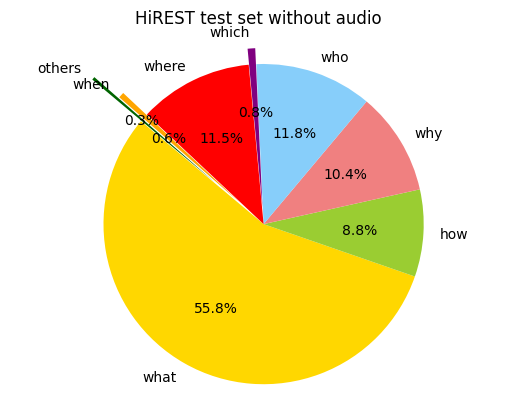

1035 181 185 227 22 226 11 3


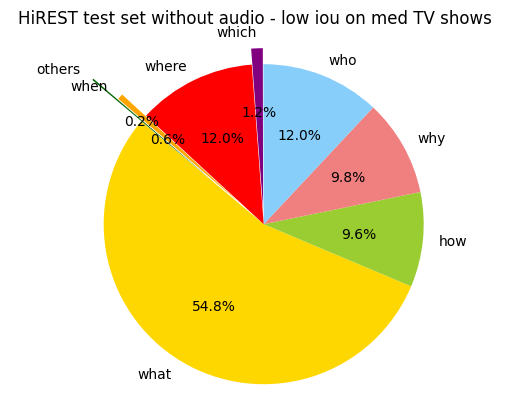

31 7 7 2 1 9 1 0


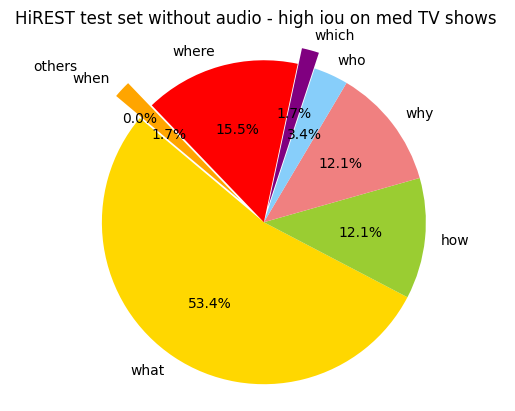

2861 393 483 574 31 571 27 15


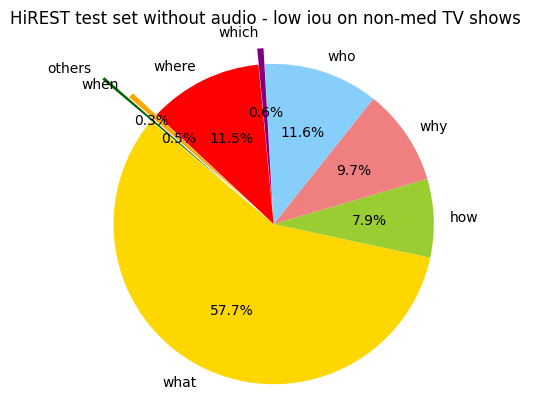

202 31 57 59 2 36 0 3


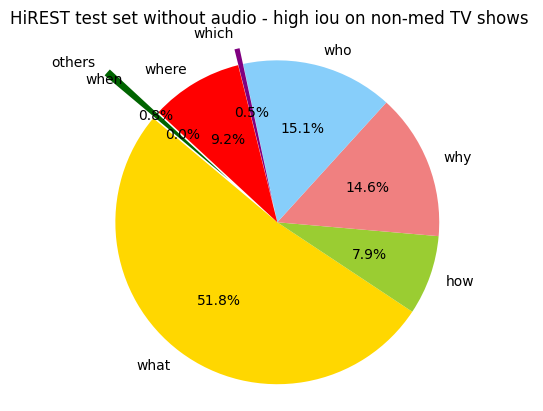

In [23]:
root_path = "/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/evaluation/tvqa"
categories = ["what", "how", "why", "who", "which", "where", "when", "others"]
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0

for q, value in test[0].items():
    if q in test_result:
        if q.lower().strip().startswith("what"):
            what_cnt += 1
        elif q.lower().strip().startswith("how"):
            how_cnt += 1
        elif q.lower().strip().startswith("why"):
            why_cnt += 1
        elif q.lower().strip().startswith("who"):
            who_cnt += 1
        elif q.lower().strip().startswith("which"):
            which_cnt += 1
        elif q.lower().strip().startswith("where"):
            where_cnt += 1
        elif q.lower().strip().startswith("when"):
            when_cnt += 1
        else:
            #print(q)
            other_cnt += 1
print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set without audio", root_path)
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0

for q in test_woa_under_thresh['med']['low']['queries']:
    if q.lower().strip().startswith("what"):
        what_cnt += 1
    elif q.lower().strip().startswith("how"):
        how_cnt += 1
    elif q.lower().strip().startswith("why"):
        why_cnt += 1
    elif q.lower().strip().startswith("who"):
        who_cnt += 1
    elif q.lower().strip().startswith("which"):
        which_cnt += 1
    elif q.lower().strip().startswith("where"):
        where_cnt += 1
    elif q.lower().strip().startswith("when"):
        when_cnt += 1
    else:
        #print(q)
        other_cnt += 1

print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set without audio - low iou on med TV shows ", root_path)
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0
for q in test_woa_under_thresh['med']['high']['queries']:
    if q.lower().strip().startswith("what"):
        what_cnt += 1
    elif q.lower().strip().startswith("how"):
        how_cnt += 1
    elif q.lower().strip().startswith("why"):
        why_cnt += 1
    elif q.lower().strip().startswith("who"):
        who_cnt += 1
    elif q.lower().strip().startswith("which"):
        which_cnt += 1
    elif q.lower().strip().startswith("where"):
        where_cnt += 1
    elif q.lower().strip().startswith("when"):
        when_cnt += 1
    else:
        #print(q)
        other_cnt += 1

print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set without audio - high iou on med TV shows ", root_path)
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0
for q in test_woa_under_thresh['nonmed']['low']['queries']:
    if q.lower().strip().startswith("what"):
        what_cnt += 1
    elif q.lower().strip().startswith("how"):
        how_cnt += 1
    elif q.lower().strip().startswith("why"):
        why_cnt += 1
    elif q.lower().strip().startswith("who"):
        who_cnt += 1
    elif q.lower().strip().startswith("which"):
        which_cnt += 1
    elif q.lower().strip().startswith("where"):
        where_cnt += 1
    elif q.lower().strip().startswith("when"):
        when_cnt += 1
    else:
        #print(q)
        other_cnt += 1

print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set without audio - low iou on non-med TV shows ", root_path)
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0
for q in test_woa_under_thresh['nonmed']['high']['queries']:
    if q.lower().strip().startswith("what"):
        what_cnt += 1
    elif q.lower().strip().startswith("how"):
        how_cnt += 1
    elif q.lower().strip().startswith("why"):
        why_cnt += 1
    elif q.lower().strip().startswith("who"):
        who_cnt += 1
    elif q.lower().strip().startswith("which"):
        which_cnt += 1
    elif q.lower().strip().startswith("where"):
        where_cnt += 1
    elif q.lower().strip().startswith("when"):
        when_cnt += 1
    else:
        #print(q)
        other_cnt += 1

print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set without audio - high iou on non-med TV shows ", root_path)

4251 670 792 902 58 877 44 24


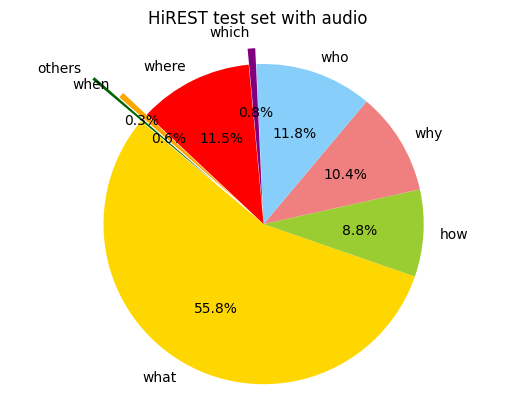

1044 184 185 226 22 230 11 3


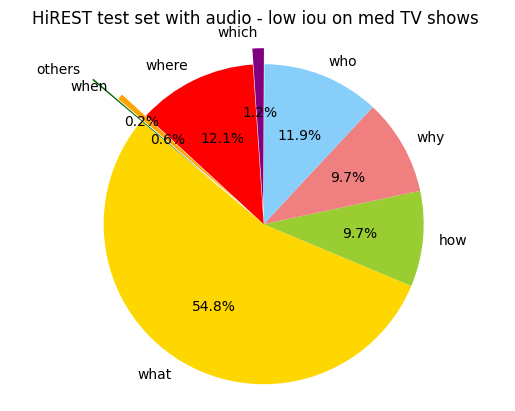

26 4 7 3 1 4 1 0


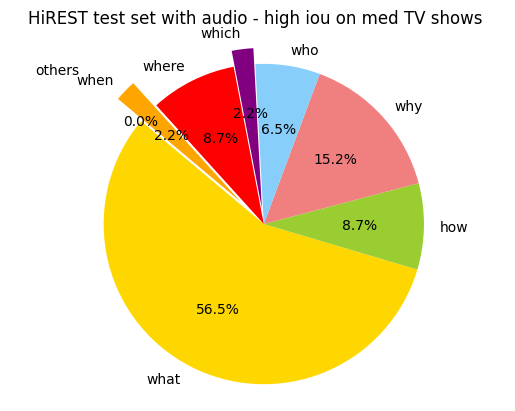

2884 405 480 579 31 567 28 15


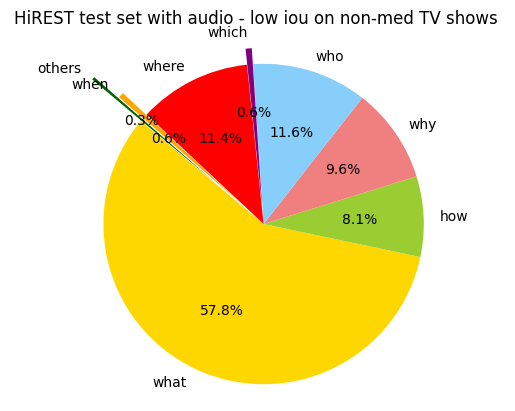

177 29 60 55 2 36 0 3


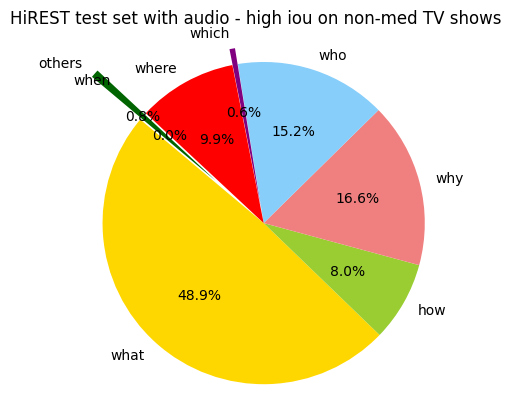

In [24]:
categories = ["what", "how", "why", "who", "which", "where", "when", "others"]
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0

for q, value in test[0].items():
    if q in hirest_test_wa_result:
        if q.lower().strip().startswith("what"):
            what_cnt += 1
        elif q.lower().strip().startswith("how"):
            how_cnt += 1
        elif q.lower().strip().startswith("why"):
            why_cnt += 1
        elif q.lower().strip().startswith("who"):
            who_cnt += 1
        elif q.lower().strip().startswith("which"):
            which_cnt += 1
        elif q.lower().strip().startswith("where"):
            where_cnt += 1
        elif q.lower().strip().startswith("when"):
            when_cnt += 1
        else:
            #print(q)
            other_cnt += 1
print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set with audio", root_path)
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0
for q in test_wa_under_thresh['med']['low']['queries']:
    if q.lower().strip().startswith("what"):
        what_cnt += 1
    elif q.lower().strip().startswith("how"):
        how_cnt += 1
    elif q.lower().strip().startswith("why"):
        why_cnt += 1
    elif q.lower().strip().startswith("who"):
        who_cnt += 1
    elif q.lower().strip().startswith("which"):
        which_cnt += 1
    elif q.lower().strip().startswith("where"):
        where_cnt += 1
    elif q.lower().strip().startswith("when"):
        when_cnt += 1
    else:
        #print(q)
        other_cnt += 1

print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set with audio - low iou on med TV shows ", root_path)
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0
for q in test_wa_under_thresh['med']['high']['queries']:
    if q.lower().strip().startswith("what"):
        what_cnt += 1
    elif q.lower().strip().startswith("how"):
        how_cnt += 1
    elif q.lower().strip().startswith("why"):
        why_cnt += 1
    elif q.lower().strip().startswith("who"):
        who_cnt += 1
    elif q.lower().strip().startswith("which"):
        which_cnt += 1
    elif q.lower().strip().startswith("where"):
        where_cnt += 1
    elif q.lower().strip().startswith("when"):
        when_cnt += 1
    else:
        #print(q)
        other_cnt += 1

print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set with audio - high iou on med TV shows ", root_path)
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0
for q in test_wa_under_thresh['nonmed']['low']['queries']:
    if q.lower().strip().startswith("what"):
        what_cnt += 1
    elif q.lower().strip().startswith("how"):
        how_cnt += 1
    elif q.lower().strip().startswith("why"):
        why_cnt += 1
    elif q.lower().strip().startswith("who"):
        who_cnt += 1
    elif q.lower().strip().startswith("which"):
        which_cnt += 1
    elif q.lower().strip().startswith("where"):
        where_cnt += 1
    elif q.lower().strip().startswith("when"):
        when_cnt += 1
    else:
        #print(q)
        other_cnt += 1

print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set with audio - low iou on non-med TV shows ", root_path)
what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt,  other_cnt = 0, 0, 0, 0, 0, 0, 0, 0
for q in test_wa_under_thresh['nonmed']['high']['queries']:
    if q.lower().strip().startswith("what"):
        what_cnt += 1
    elif q.lower().strip().startswith("how"):
        how_cnt += 1
    elif q.lower().strip().startswith("why"):
        why_cnt += 1
    elif q.lower().strip().startswith("who"):
        who_cnt += 1
    elif q.lower().strip().startswith("which"):
        which_cnt += 1
    elif q.lower().strip().startswith("where"):
        where_cnt += 1
    elif q.lower().strip().startswith("when"):
        when_cnt += 1
    else:
        #print(q)
        other_cnt += 1

print(what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt )
piechart(categories, [what_cnt, how_cnt, why_cnt, who_cnt, which_cnt, where_cnt, when_cnt, other_cnt ], "HiREST test set with audio - high iou on non-med TV shows ", root_path)


In [48]:
import nltk
from nltk.tag.stanford import StanfordNERTagger
st = StanfordNERTagger('/home/hlpark/stanford-ner/english.all.3class.distsim.crf.ser.gz',
                       '/home/hlpark/stanford-ner/stanford-ner.jar')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
def tag(text):
    people = []
    for sent in nltk.sent_tokenize(text):
        tokens = nltk.tokenize.word_tokenize(sent)
        tags = st.tag(tokens)
        for tag in tags:
            if tag[1]=='PERSON': 
                people.append(tag)
    return people

[nltk_data] Downloading package punkt to /home/hlpark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hlpark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hlpark/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/hlpark/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/hlpark/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [63]:
med_high_cnt = 0
for q in test_woa_under_thresh['med']['high']['queries']:
    q_temp = q
    output = tag(q_temp) 
    if output != None and len(output) > 0:
        med_high_cnt += 1
        # print(q_temp, output)
    else:
        print(q)
print(med_high_cnt, "/", len(test_woa_under_thresh['med']['high']['queries']))


med_low_cnt = 0
for q in test_woa_under_thresh['med']['low']['queries']:
    q_temp = q
    output = tag(q_temp) 
    if output != None and len(output) > 0:
        med_low_cnt += 1
        # print(q_temp, output)
    # else:
    #     print(q)

print(med_low_cnt, "/", len(test_woa_under_thresh['med']['low']['queries']))

nonmed_high_cnt = 0
for q in test_woa_under_thresh['nonmed']['high']['queries']:
    q_temp = q
    output = tag(q_temp) 
    if output != None and len(output) > 0:
        nonmed_high_cnt += 1
        # print(q_temp, output)
    # else:
    #     print(q)

print(nonmed_high_cnt, "/", len(test_woa_under_thresh['nonmed']['high']['queries']))

nonmed_low_cnt = 0
for q in test_woa_under_thresh['nonmed']['low']['queries']:
    q_temp = q
    output = tag(q_temp) 
    if output != None and len(output) > 0:
        nonmed_low_cnt += 1
        # print(q_temp, output)
    # else:
    #     print(q)

print(nonmed_low_cnt, "/", len(test_woa_under_thresh['nonmed']['low']['queries']))

Where and when was the doctor was?
Where did House go after the doctors thought that she might need a liver transplant?
Where and when happen after?
What relationship did the girl have to the patient in the bed discovered when they were talking to each other?
how many metabolic conditions did House state there were when talking to the woman in the beginning?
What does the co-worker act like after the team leaves the office and encounters him
Where and when did House talk about the muscle tear?
What happened after Athena asked "what's happening?"
What did House say after Thirteen said no one will help the patient?
What did Chase say after House recommended to put her on steroids?
What was the mom concerned about when talking to the daughter?
What was the daughter's response when the mom tried to take the blame?
What was House doing after the scene with the other doctors?
Who was Athena talking to after she said "I cant respect a man that is desperate enough to swallow my exit strategy"


In [ ]:
import spacy
nlp = spacy.load("en_core_sci_sm")